# Objects

In [152]:
%load_ext autoreload
%autoreload 2

import sys, os
import requests
import pandas as pd
import json
import talib
import numpy as np
import time

import yfinance as yf
import warnings
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import warnings
warnings.filterwarnings('ignore')


SECRET_FP = "./secrets.json"
with open(SECRET_FP, 'r') as file:
    secrets = json.load(file)
API_KEY = secrets['eodhd_api_key']

sys.path.append(r"C:\Users\micha\OneDrive\Documents\code\submodule")
from eodhd import Underlying, Chain, ChainHistory
import plot
from plot import ChartStyle
cs = ChartStyle(figsize=(20,8),nyears=1, date_fmt="%Y-%m", grid=False)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Chain

In [208]:
# undr = Underlying(ticker = 'SPY')
# undr.last_price
# undr.prices
# undr.returns
# # display(undr.rsi(period=14))
# undr.last_rsi

chain = Chain(ticker = 'IVV', max_expiration="2026-01-31")
calls = chain.calls
puts = chain.puts
atm = chain.atm
d25 = chain.delta_twenty_five
chain.get_atm_avg()

df = chain.atm.copy()
df['exp_date'] = pd.to_datetime(df['exp_date'])
atm_calls = df[df['type'] == 'call'].sort_values('exp_date')
atm_puts = df[df['type'] == 'put'].sort_values('exp_date')

Total records to fetch: 2046
Fetched 1000 rows at offset 0
Fetched 1000 rows at offset 1000
Fetched 46 rows at offset 2000


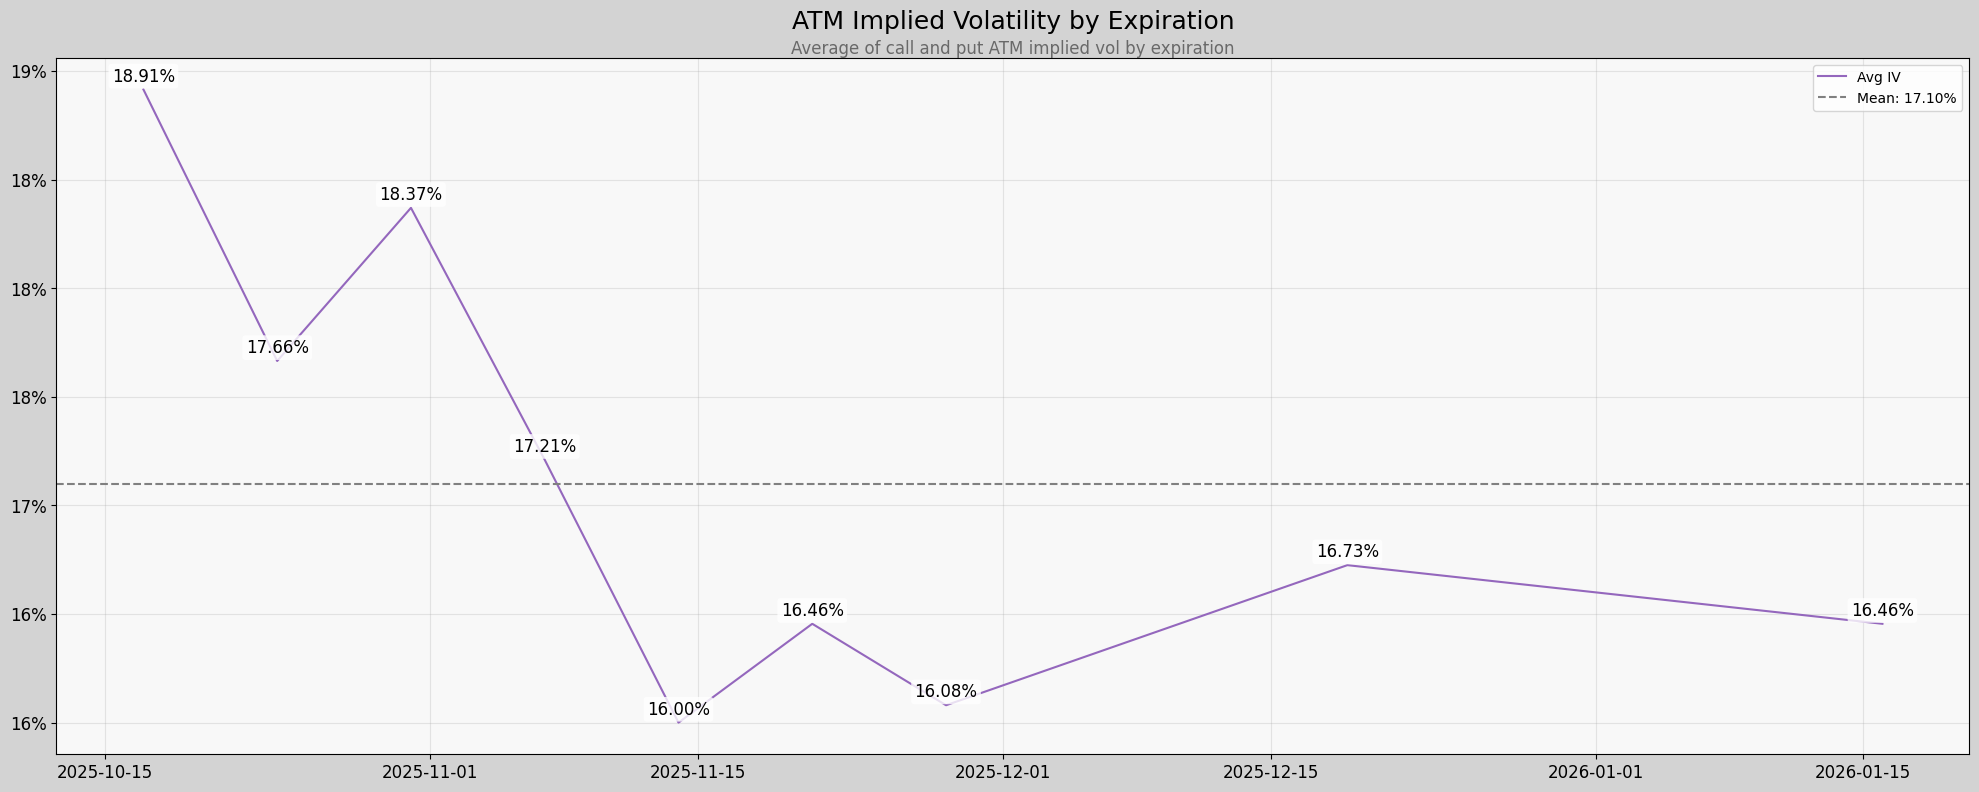

In [ ]:
res = atm_calls.merge(atm_puts, on='exp_date', suffixes=('_call', '_put'), how='inner', validate='one_to_one', indicator=True)[['exp_date', 'volatility_call', 'volatility_put']]
res['ivol'] = (res['volatility_call'] + res['volatility_put']) / 2

res = atm_calls.merge(
    atm_puts,
    on='exp_date',
    suffixes=('_call', '_put'),
    how='inner',
    validate='one_to_one',
    indicator=True
)[['exp_date', 'volatility_call', 'volatility_put']].copy()
res['exp_date'] = pd.to_datetime(res['exp_date'])
res = res.sort_values('exp_date')
res['ivol'] = (res['volatility_call'] + res['volatility_put']) / 2

# single-line plot of the average (ivol)
ax = plot.plot_line(
    x=res['exp_date'],
    y=res['ivol'],
    date_axis=False,
    style=cs,
    title="ATM Implied Volatility by Expiration",
    subtitle="Average of call and put ATM implied vol by expiration",
    style_kwargs={"subtitle_size": 12},
    grid=True,
    label="Avg IV",
    annotate_last=False,
    annotate_last_fmt="{:.2%}",
    y_fmt="{:,.0%}",
    color="tab:purple",
)


for x, y in zip(res['exp_date'], res['ivol']):
    ax.annotate(f"{y:.2%}",
                xy=(x, y),
                xytext=(0, 6),
                textcoords="offset points",
                ha="center",
                fontsize=12,
                # color='tab:blue',
                zorder=4,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8))


ax.axhline(y=res['ivol'].mean(), color='gray', linestyle='--', label=f'Mean: {res["ivol"].mean():.2%}')
ax.legend()

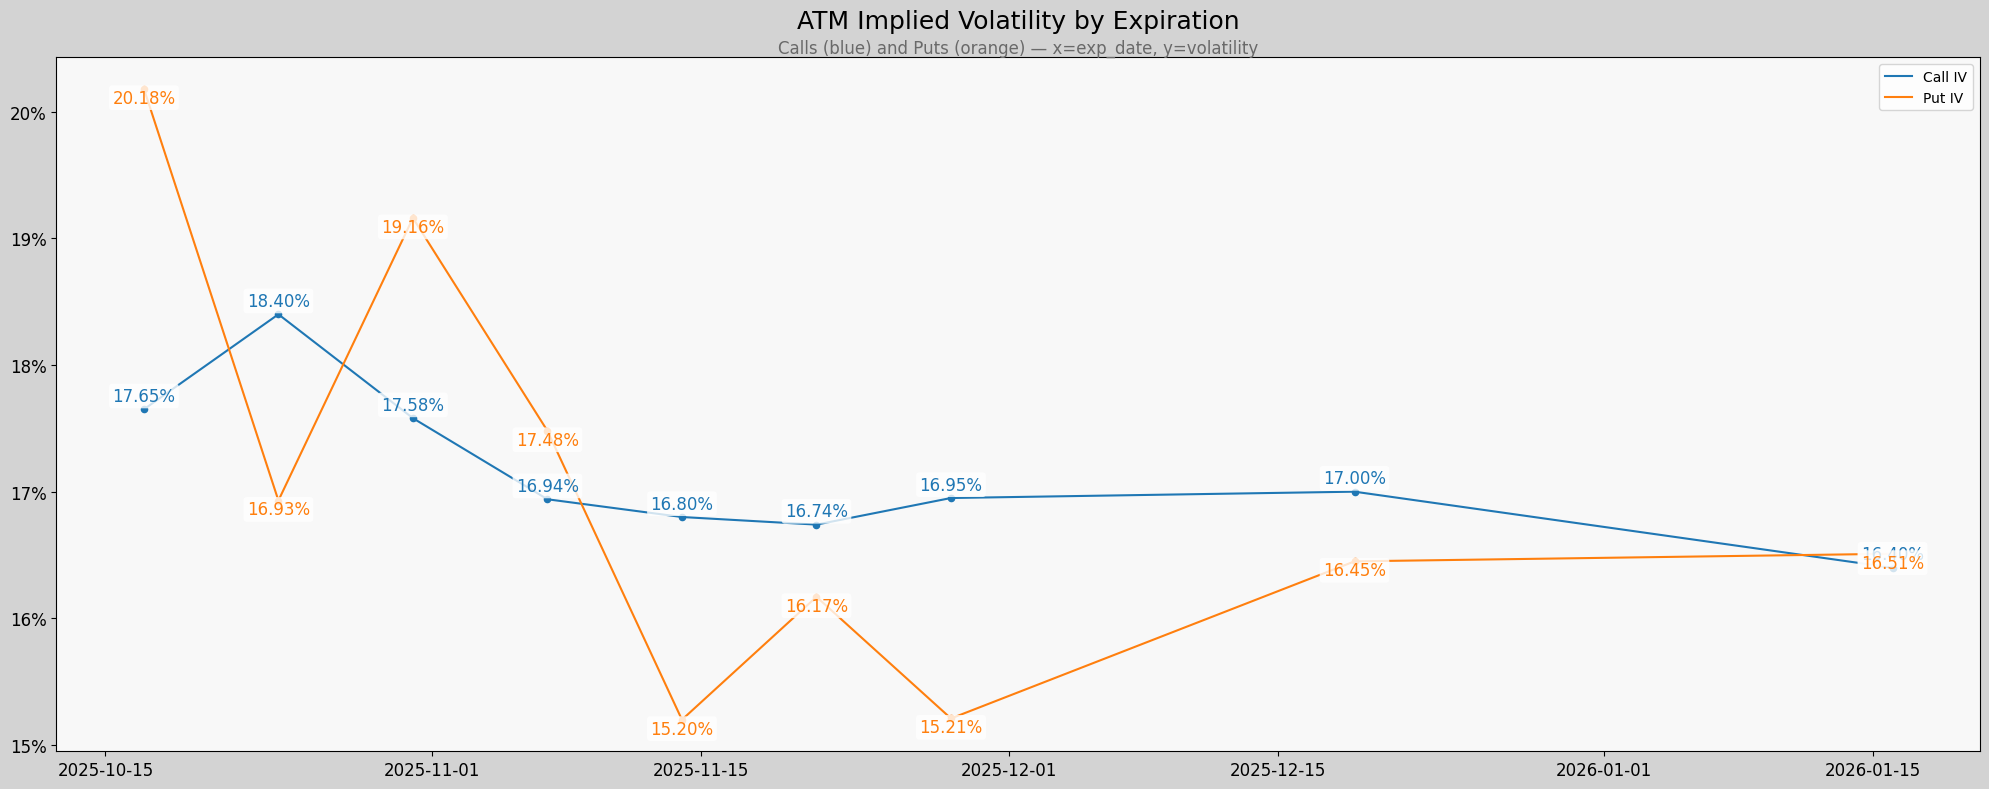

In [ ]:

ax = plot.plot_line(
    x=atm_calls['exp_date'],
    y=atm_calls['volatility'],
    date_axis=False,
    style=cs,
    title="ATM Implied Volatility by Expiration",
    subtitle="",
    style_kwargs={"subtitle_size": 12},
    grid=True,
    label="Call IV",
    annotate_last=False,
    annotate_last_fmt="{:.2%}",
    y_fmt="{:,.0%}",
)

plot.plot_line(
    x=atm_puts['exp_date'],
    y=atm_puts['volatility'],
    ax=ax,
    date_axis=False,
    style=cs,
    label="Put IV",
    color="tab:orange",
    annotate_last=False,
    annotate_last_fmt="{:.2%}",
    y_fmt="{:,.0%}",
)

ax.scatter(atm_calls['exp_date'], atm_calls['volatility'], color='tab:blue', s=20, zorder=3)
ax.scatter(atm_puts['exp_date'], atm_puts['volatility'], color='tab:orange', s=20, zorder=3)

for x, y in zip(atm_calls['exp_date'], atm_calls['volatility']):
    ax.annotate(f"{y:.2%}",
                xy=(x, y),
                xytext=(0, 6),
                textcoords="offset points",
                ha="center",
                fontsize=12,
                color='tab:blue',
                zorder=4,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8))

for x, y in zip(atm_puts['exp_date'], atm_puts['volatility']):
    ax.annotate(f"{y:.2%}",
                xy=(x, y),
                xytext=(0, -10),
                textcoords="offset points",
                ha="center",
                fontsize=12,
                color='tab:orange',
                zorder=4,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8))

ax.legend()

# Chain History

In [180]:
ch = ChainHistory(ticker="IVV", start="2024-09-05", end="2025-10-15", chunk_size=15, refresh=False)
hist = ch.history
trd = ch.trades

hist_atm = ch.get_timeseries_by_delta(delta_target=0.5, delta_tolerance=0.1, trades=True) 
dte_30 = ch.get_n_dte_timeseries(n_days=30, trades=True)
delta_25_dte_30 = ch.get_time_series_n_dte_by_delta(n_days=30, delta_target=0.25, delta_tolerance=0.1, trades=True)

pcs = ch.get_pc_spread(df=delta_25_dte_30)
pcs_rank = ch.get_pc_spread_rank(df=pcs)
pcs_rolling = ch.get_pc_spread_rolling(df=pcs, window=20)

ivol_rank = ch.get_ivol_rank(df=pcs)

iv_rank, vw_iv_percentile = ch.get_iv_rank(df=hist_atm)
iv_rank_roll = ch.get_iv_rank_rolling(df=hist_atm, window=20)

Loading existing data from C:\Users\micha\OneDrive\Documents\data\eodhd_options\\IVV_Chain_History_2024-09-05_2025-10-15.pkl


In [ ]:
cols_view = ['tradetime', 'contract', 'underlying_symbol', 'expiration_type', 'exp_date',  'type', 'strike','dte', 'delta', 'volatility',  'volume']
cols_greeks = ['delta', 'gamma', 'theta', 'vega', 'rho']
cols_trade = [ 'open', 'high', 'low', 'last', 'last_size', 'change', 'pctchange', 'previous', 'previous_date', 'bid', 'bid_date', 'bid_size', 'ask', 'ask_date', 'ask_size','moneyness', 
              'volume', 'volume_change', 'volume_pctchange', 'open_interest','open_interest_change', 'open_interest_pctchange', 'theoretical', 'vol_oi_ratio']

In [141]:
ch.history

,contract,underlying_symbol,exp_date,expiration_type,type,strike,exchange,currency,open,high,...,theoretical,delta,gamma,theta,vega,rho,tradetime,vol_oi_ratio,dte,midpoint
0,IVV251219C00465000,IVV,2025-12-19,monthly,call,465.0,AMEX,USD,0.00,0.00,...,120.70,0.843066,0.001717,-0.076824,0.999999,0.999999,2024-09-19,0.00,272.0,120.70
1,IVV251219C00465000,IVV,2025-12-19,monthly,call,465.0,AMEX,USD,0.00,0.00,...,120.70,0.844533,0.001715,-0.075791,0.999999,0.999999,2024-09-19,0.00,274.0,120.70
2,IVV251219C00465000,IVV,2025-12-19,monthly,call,465.0,AMEX,USD,0.00,0.00,...,122.65,0.841629,0.001686,-0.077764,0.999999,0.999999,2024-09-19,0.00,275.0,122.65
3,IVV251219C00465000,IVV,2025-12-19,monthly,call,465.0,AMEX,USD,0.00,0.00,...,117.30,0.832177,0.001788,-0.078489,0.999999,0.999999,2024-09-19,0.00,276.0,117.30
4,IVV251219C00465000,IVV,2025-12-19,monthly,call,465.0,AMEX,USD,0.00,0.00,...,123.20,0.849752,0.001665,-0.074294,0.999999,0.999999,2024-09-19,0.00,277.0,123.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207846,IVV251017P00672000,IVV,2025-10-17,monthly,put,672.0,AMEX,USD,7.10,7.10,...,7.10,-0.731468,0.036786,-0.343877,0.229483,-0.041297,2025-10-13,2.00,4.0,7.55
207847,IVV251017P00673000,IVV,2025-10-17,monthly,put,673.0,AMEX,USD,7.30,7.30,...,7.30,-0.828044,0.045291,-0.196697,0.176381,-0.039747,2025-10-13,0.08,4.0,8.35
207848,IVV251017P00674000,IVV,2025-10-17,monthly,put,674.0,AMEX,USD,11.55,11.55,...,9.20,-0.755158,0.029016,-0.399197,0.218711,-0.042359,2025-10-13,0.10,4.0,9.20
207849,IVV251017P00677000,IVV,2025-10-17,monthly,put,677.0,AMEX,USD,13.89,13.89,...,11.50,-0.843237,0.024598,-0.284757,0.166686,-0.042576,2025-10-13,1.00,4.0,11.50


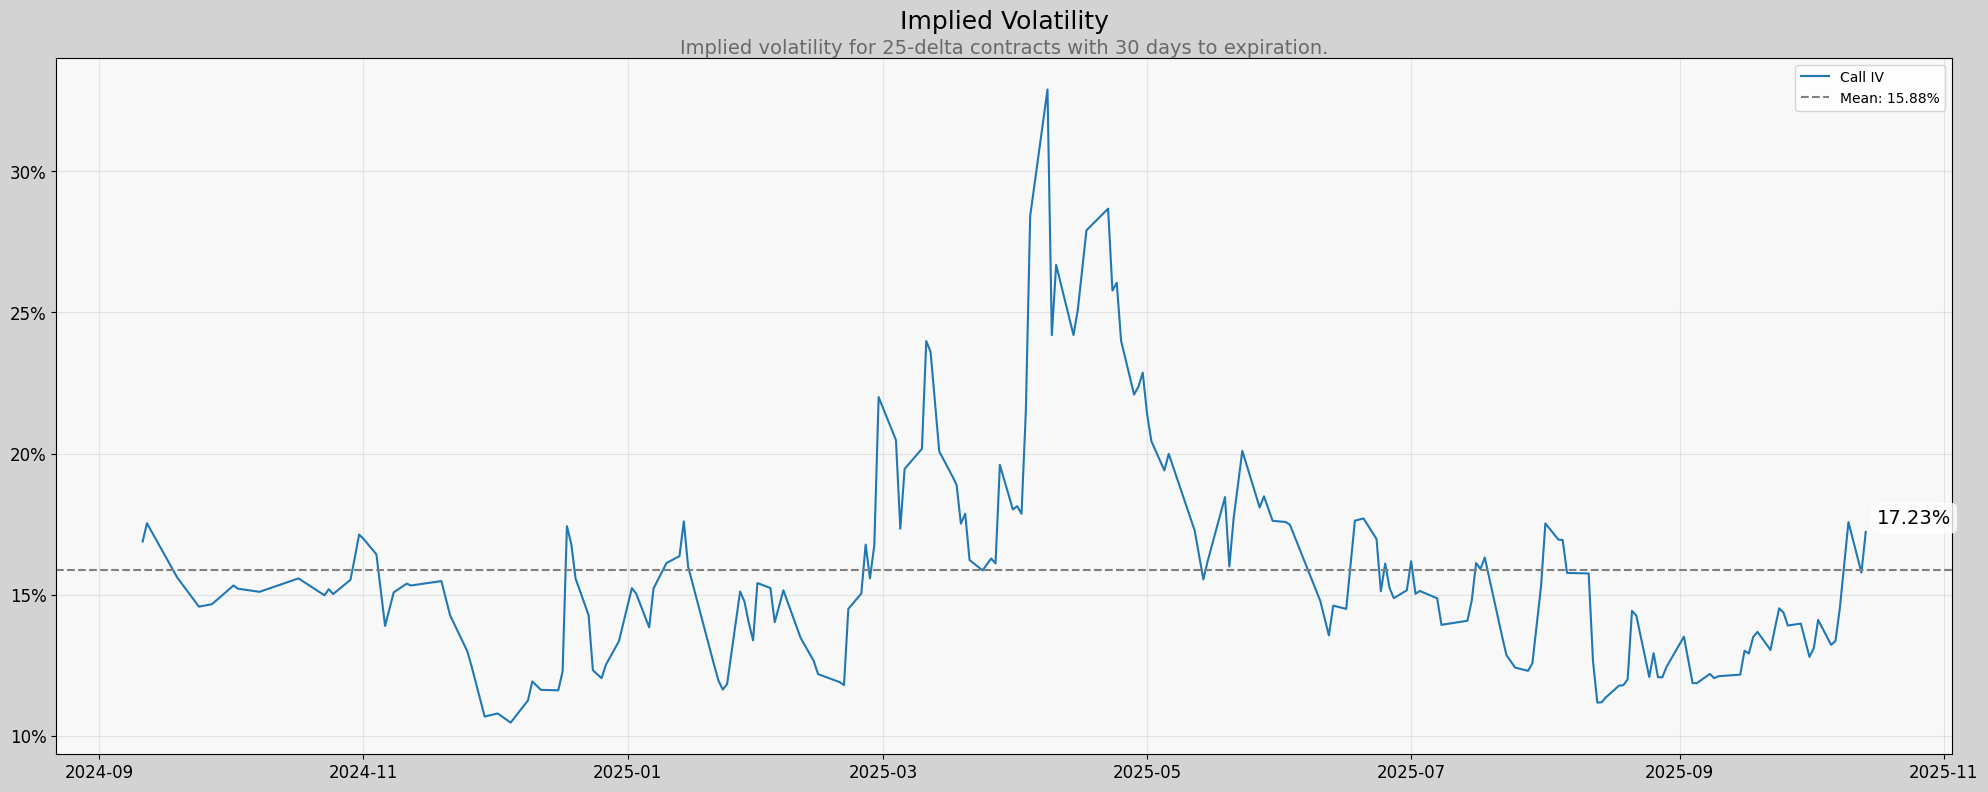

In [173]:
ax = plot.plot_line(
    x=pcs['tradetime'],
    y=pcs['ivol'],
    date_axis=False,
    style=cs,
    title="Implied Volatility",
    subtitle="Implied volatility for 25-delta contracts with 30 days to expiration.",
    style_kwargs={"subtitle_size": 14},
    grid=True,
    label="Call IV",
    annotate_last=True,
    annotate_last_fmt="{:.2%}",
    y_fmt="{:,.0%}",
)
ax.axhline(y=pcs['ivol'].mean(), color='gray', linestyle='--', label=f'Mean: {pcs["ivol"].mean():.2%}')
plt.legend()

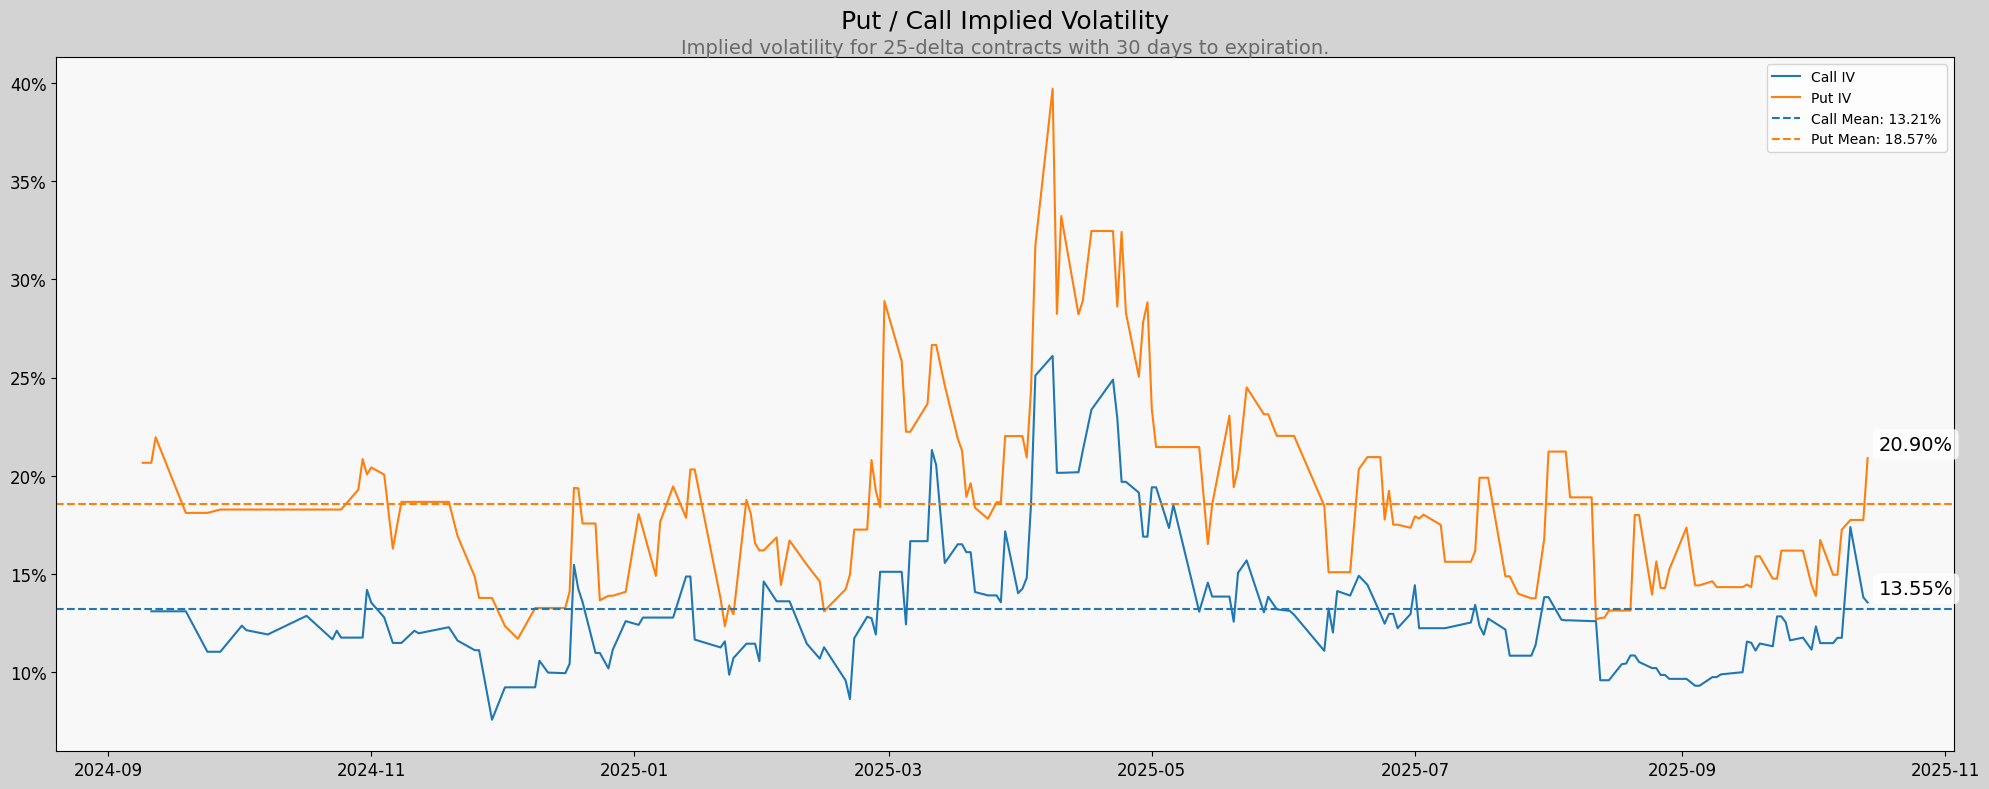

In [174]:
ax = plot.plot_line(
    x=pcs['tradetime'],
    y=pcs['call_vol'],
    date_axis=False,
    style=cs,
    title="Put / Call Implied Volatility",
    subtitle="Implied volatility for 25-delta contracts with 30 days to expiration.",
    style_kwargs={"subtitle_size": 14},
    grid=True,
    label="Call IV",
    annotate_last=True,
    annotate_last_fmt="{:.2%}",
    y_fmt="{:,.0%}",
)
plot.plot_line(
    x=pcs['tradetime'],
    y=pcs['put_vol'],
    ax=ax,
    date_axis=False,
    style=cs,
    label="Put IV",
    annotate_last=True,
    annotate_last_fmt="{:.2%}",
    y_fmt="{:,.0%}",
    color="tab:orange",
)
ax.axhline(y=pcs['call_vol'].mean(), color='tab:blue', linestyle='--', label=f'Call Mean: {pcs["call_vol"].mean():.2%}')
ax.axhline(y=pcs['put_vol'].mean(), color='tab:orange', linestyle='--', label=f'Put Mean: {pcs["put_vol"].mean():.2%}')
ax.legend()

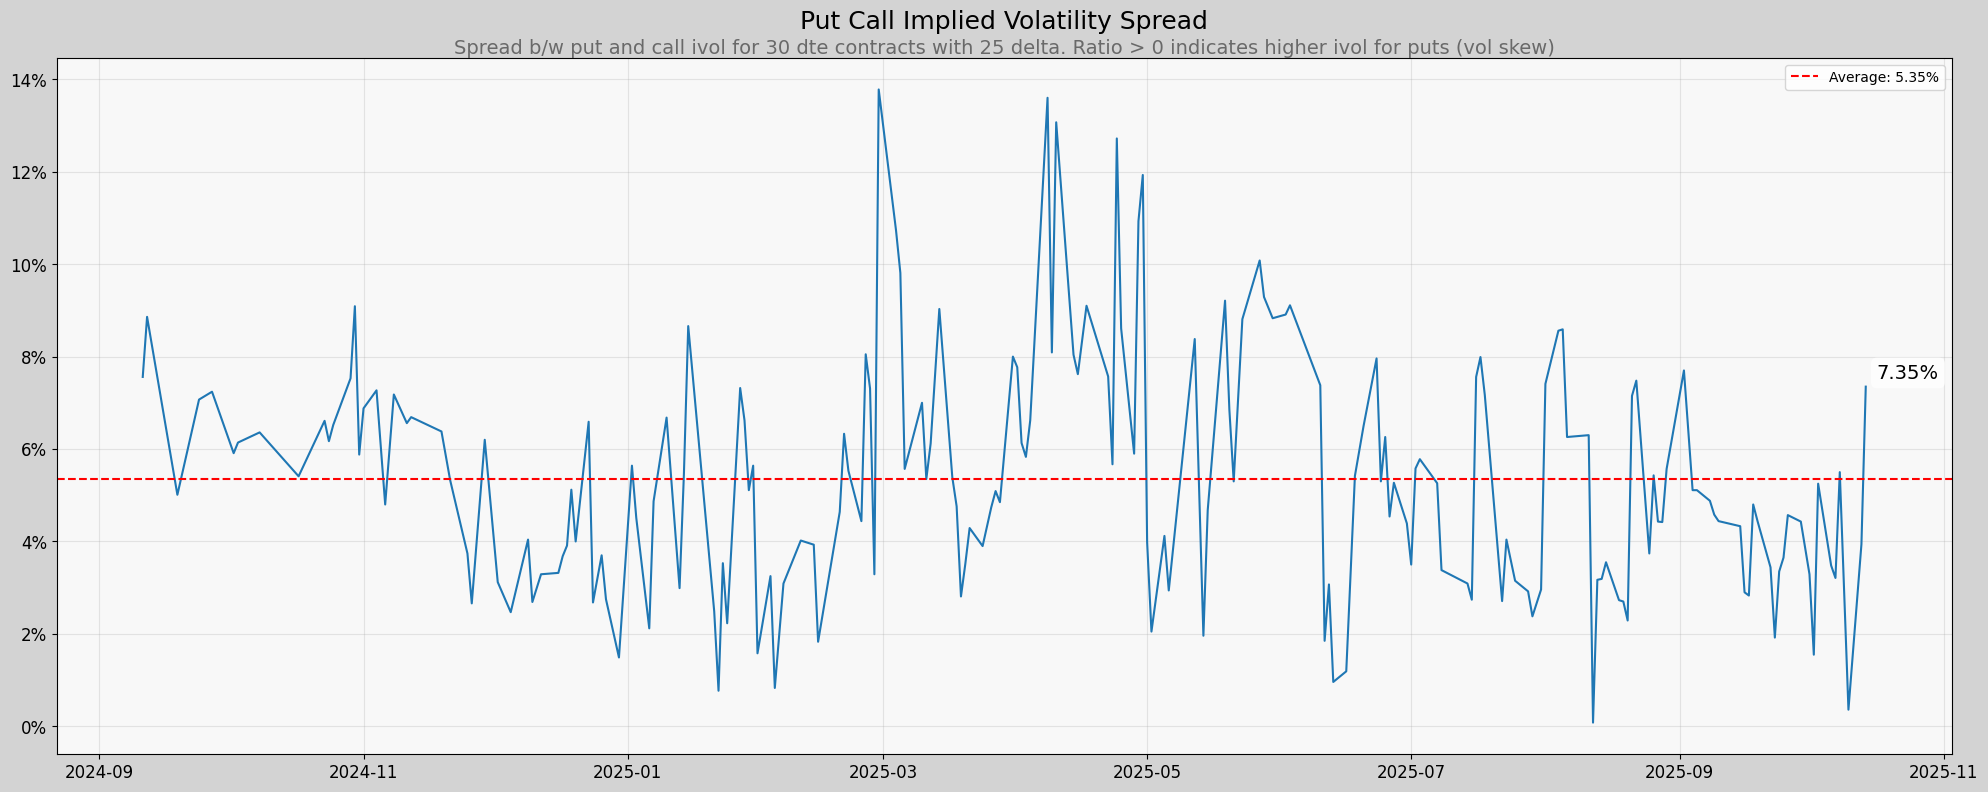

In [163]:
ax = plot.plot_line(
    x=pcs['tradetime'],
    y=pcs['pc_spread'],
    date_axis=False,
    style=cs,
    title="Put Call Implied Volatility Spread",
    subtitle="Spread b/w put and call ivol for 30 dte contracts with 25 delta. Ratio > 0 indicates higher ivol for puts (vol skew)",
    style_kwargs = {"subtitle_size": 14},
    grid=True,
    annotate_last=True,
    annotate_last_fmt="{:.2%}",
    y_fmt="{:,.0%}",
    legend=True
)
ax.axhline(pcs['pc_spread'].mean(), color='red', linestyle='--', label=f'Average: {pcs["pc_spread"].mean():.2%}')
plt.legend()

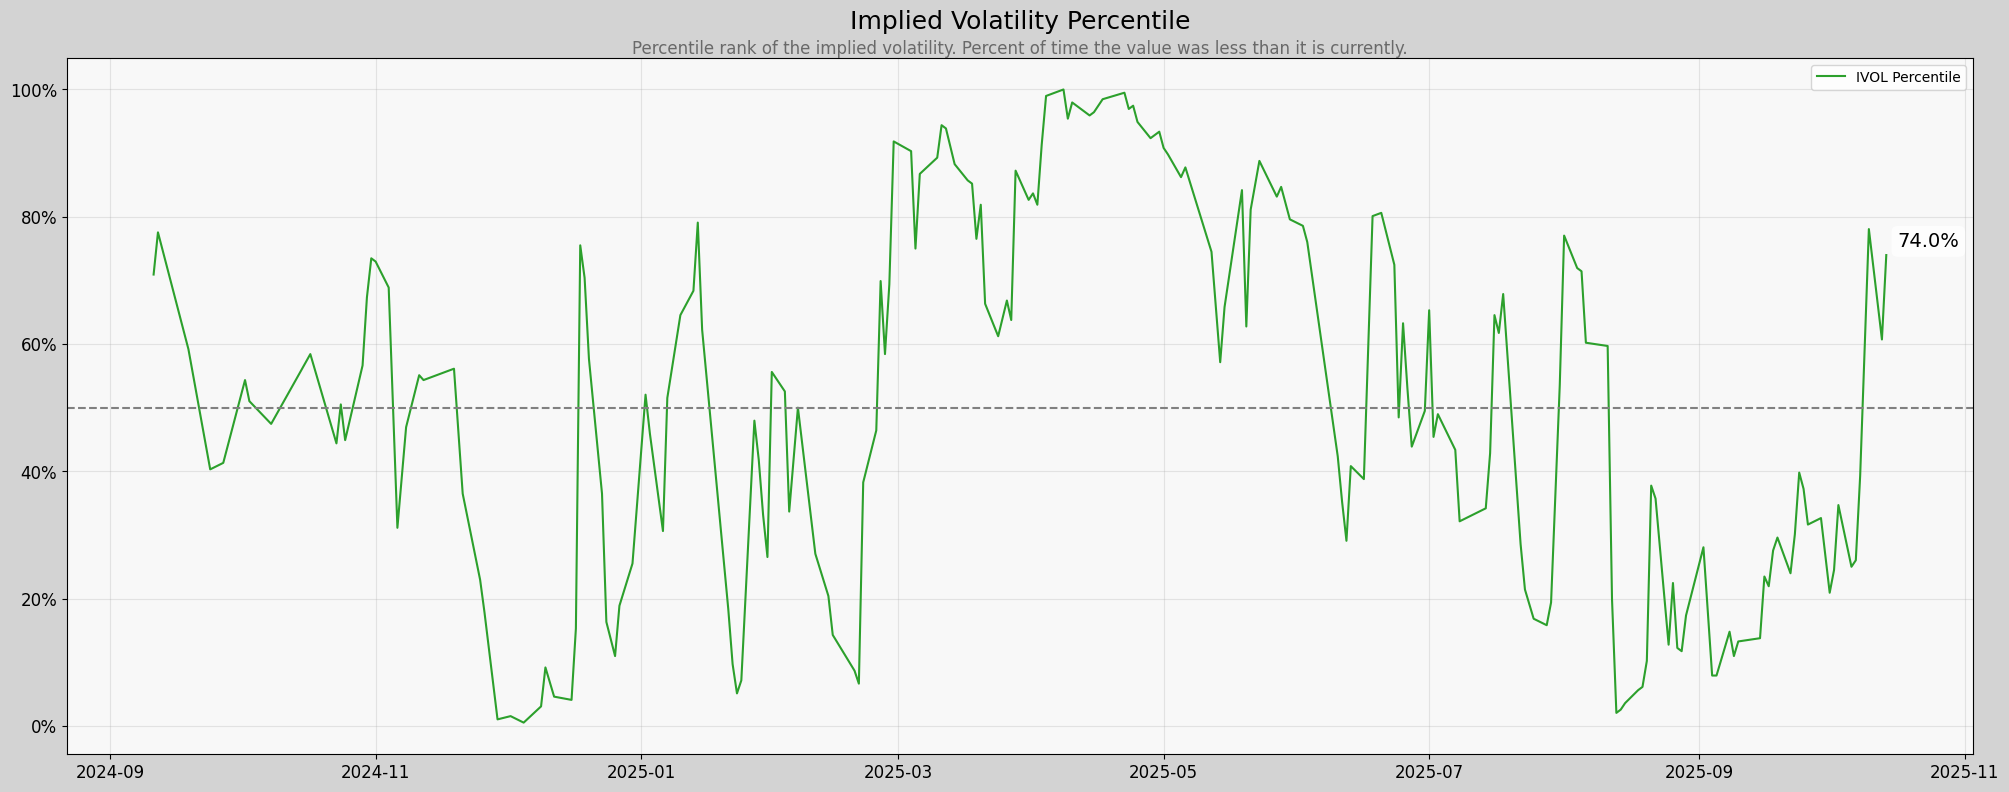

In [183]:
ax = plot.plot_line(
    x=ivol_rank['tradetime'],
    y=ivol_rank['ivol_percentile'],
    date_axis=False,
    style=cs,
    title="Implied Volatility Percentile",
    subtitle="Percentile rank of the implied volatility. Percent of time the value was less than it is currently.",
    style_kwargs={"subtitle_size": 12},
    grid=True,
    label="IVOL Percentile",
    annotate_last=True,
    annotate_last_fmt="{:.1%}",
    y_fmt="{:.0%}",
    color="tab:green",
)
ax.axhline(y=.5, color='gray', linestyle='--', )
ax.legend()

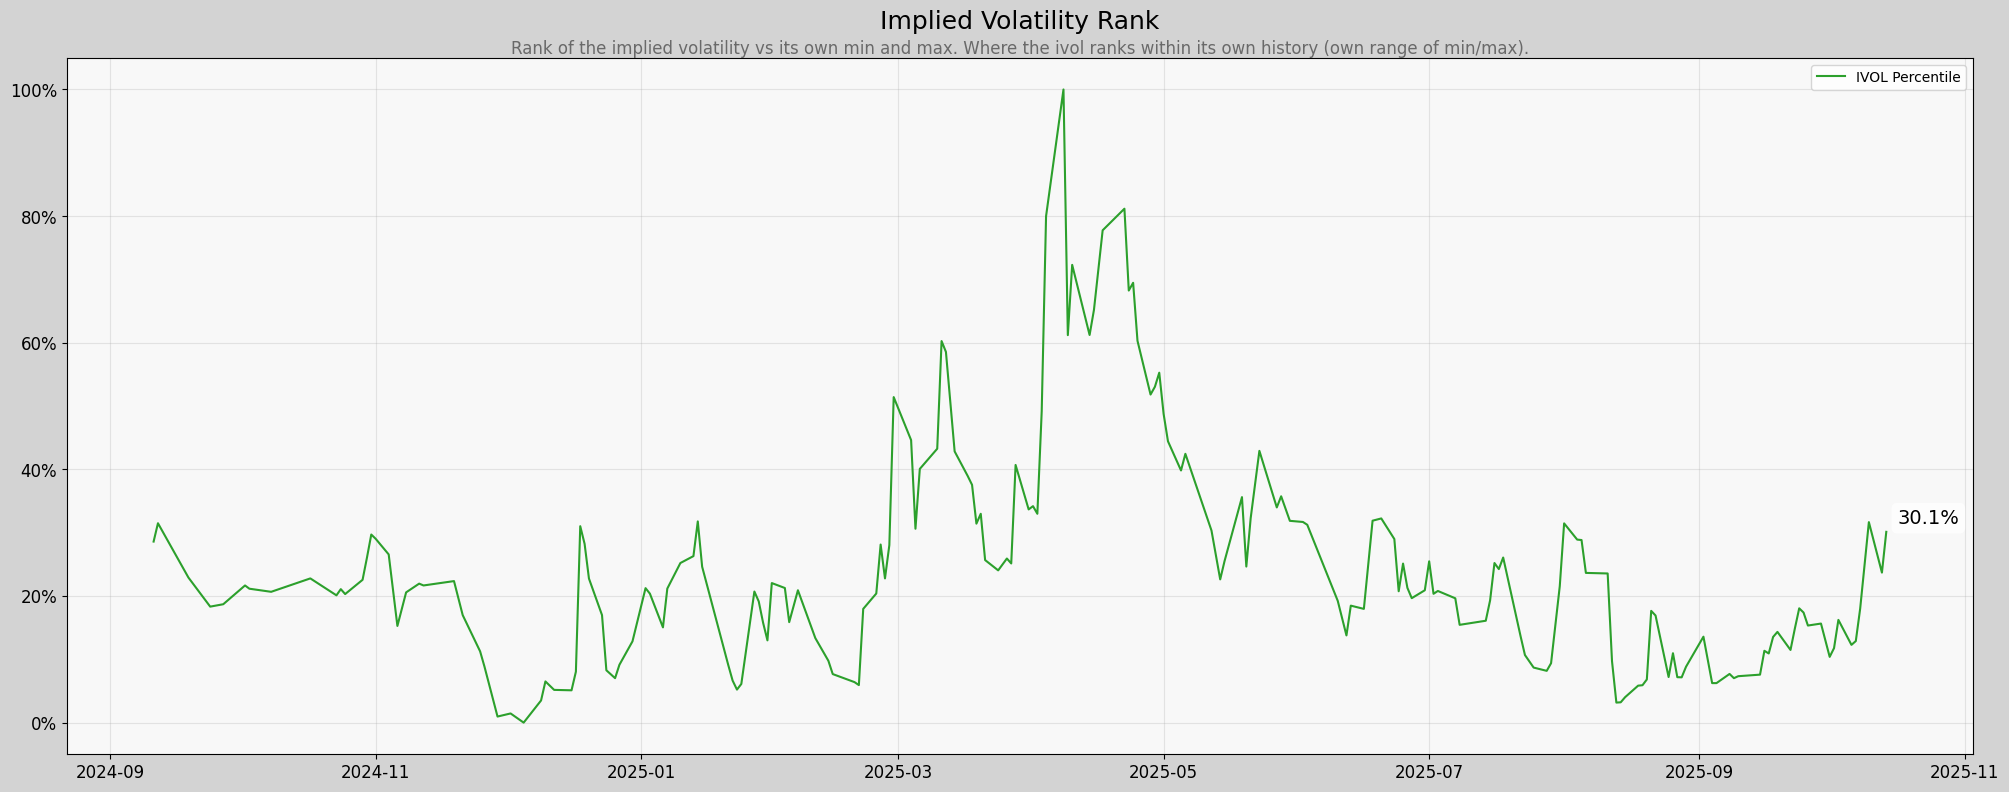

In [181]:
ax = plot.plot_line(
    x=ivol_rank['tradetime'],
    y=ivol_rank['ivol_rank'],
    date_axis=False,
    style=cs,
    title="Implied Volatility Rank",
    subtitle="Rank of the implied volatility vs its own min and max. Where the ivol ranks within its own history (own range of min/max).",
    style_kwargs={"subtitle_size": 12},
    grid=True,
    label="IVOL Percentile",
    annotate_last=True,
    annotate_last_fmt="{:.1%}",
    y_fmt="{:.0%}",
    color="tab:green",
)
ax.legend()

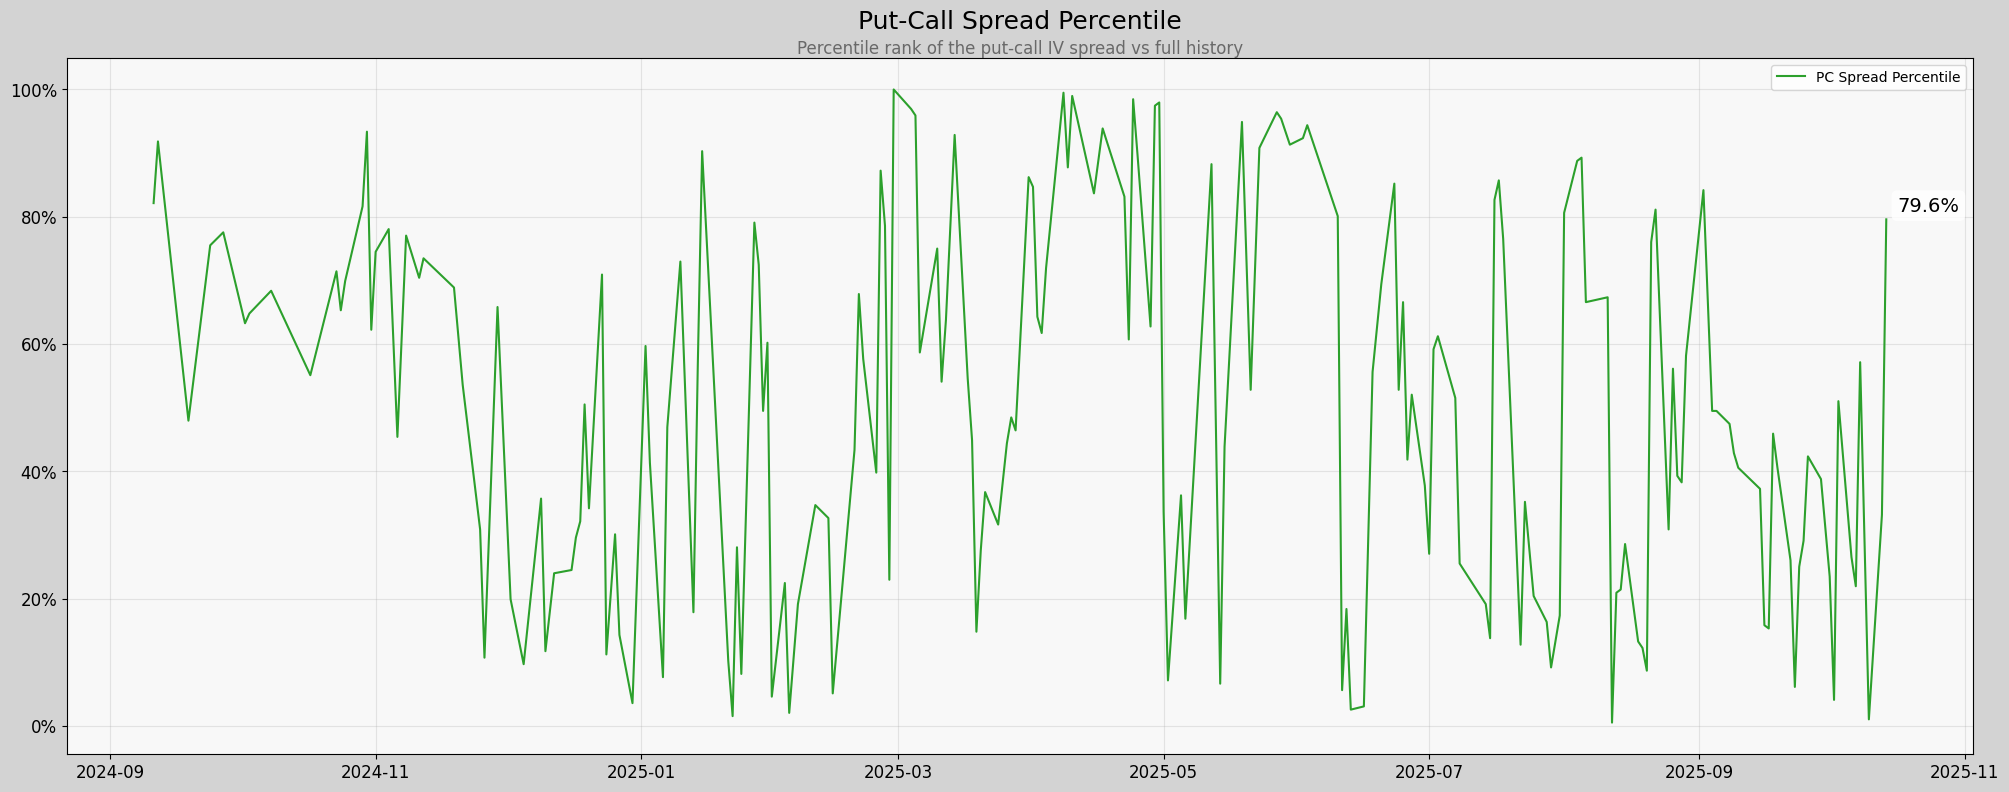

In [ ]:
ax = plot.plot_line(
    x=pcs_rank['tradetime'],
    y=pcs_rank['pc_spread_percentile'],
    date_axis=False,
    style=cs,
    title="Put-Call Spread Percentile",
    subtitle="Percentile rank of the put-call IV spread vs full history",
    style_kwargs={"subtitle_size": 12},
    grid=True,
    label="PC Spread Percentile",
    annotate_last=True,
    annotate_last_fmt="{:.1%}",
    y_fmt="{:.0%}",
    color="tab:green",
)
ax.legend()

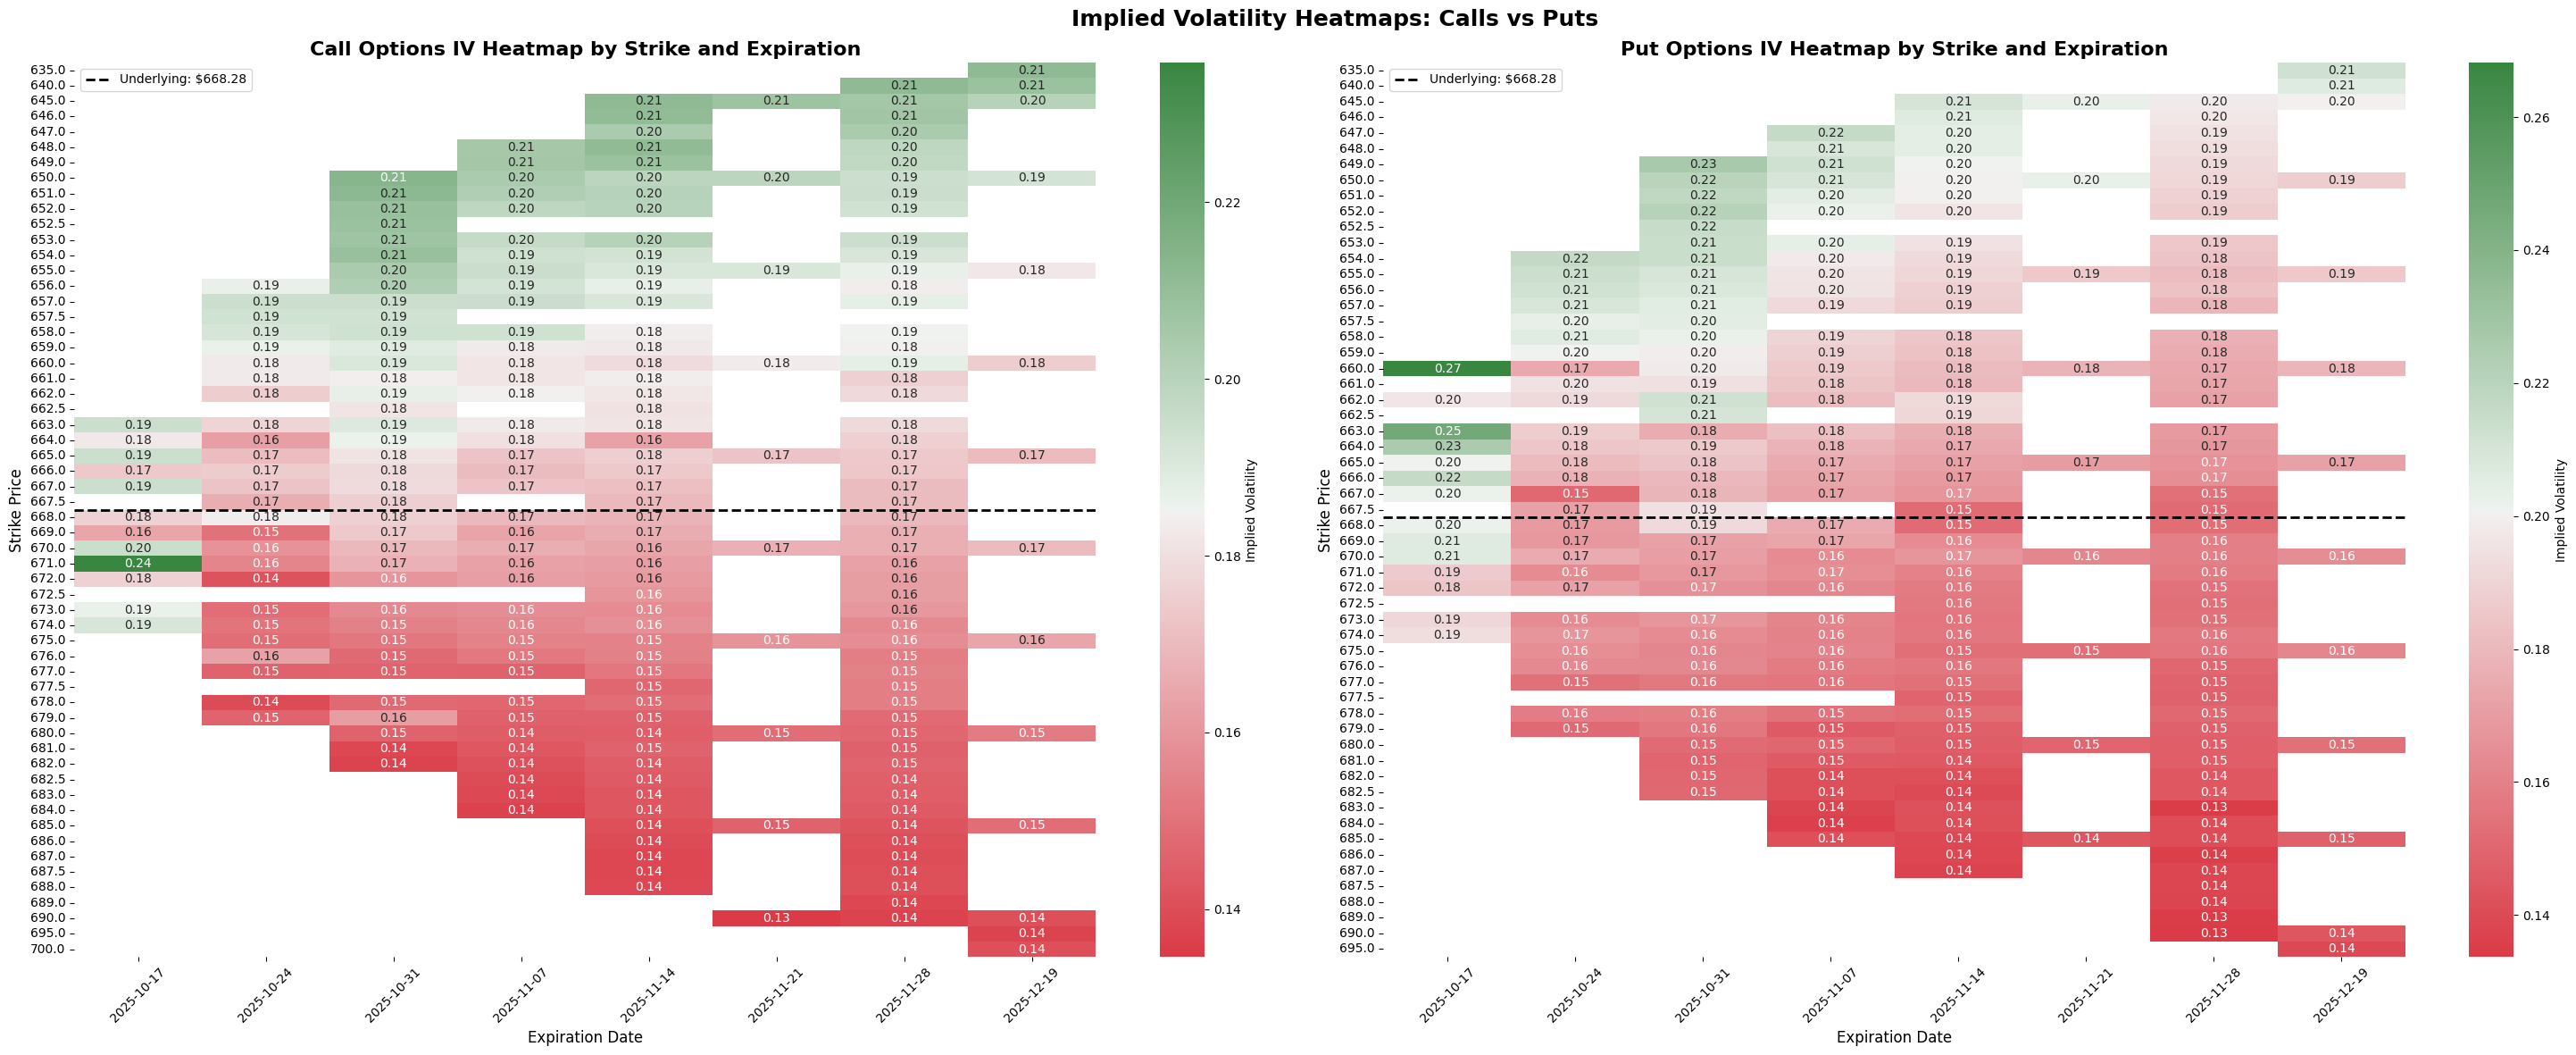


Volatility Data Summary:
Underlying Price: $668.28
Calls - Shape: (58, 8)
Calls - IV Range: 0.135 - 0.236
Calls - Mean IV: 0.173
Puts - Shape: (57, 8)
Puts - IV Range: 0.134 - 0.268
Puts - Mean IV: 0.178


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get data for both calls and puts
call_volatility_data = chain.get_strike_by_expiry(type='call', values='volatility')
put_volatility_data = chain.get_strike_by_expiry(type='put', values='volatility')

# Create colormap
cmap = sns.diverging_palette(10, 130, as_cmap=True)  # 10=red, 130=green

# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 12))

# Get underlying price
underlying_price = chain.underlying.last_price

# Left subplot: Calls
if not call_volatility_data.empty:
    heatmap1 = sns.heatmap(
        call_volatility_data, 
        annot=True, 
        fmt='.2f', 
        cmap=cmap,
        cbar_kws={'label': 'Implied Volatility'},
        # linewidths=0.5,
        # linecolor='black',
        ax=ax1
    )
    
    # Add horizontal line at underlying price
    ax1.axhline(y=call_volatility_data.index.get_loc(call_volatility_data.index[call_volatility_data.index <= underlying_price].max()), 
                color='black', linestyle='--', linewidth=2, label=f'Underlying: ${underlying_price:.2f}')
    
    # Customize calls plot
    ax1.set_title('Call Options IV Heatmap by Strike and Expiration', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Expiration Date', fontsize=12)
    ax1.set_ylabel('Strike Price', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.tick_params(axis='y', rotation=0)
    ax1.legend(loc='upper left')

# Right subplot: Puts
if not put_volatility_data.empty:
    heatmap2 = sns.heatmap(
        put_volatility_data, 
        annot=True, 
        fmt='.2f', 
        cmap=cmap,
        cbar_kws={'label': 'Implied Volatility'},
        # linewidths=0.5,
        # linecolor='black',
        ax=ax2
    )
    
    # Add horizontal line at underlying price
    ax2.axhline(y=put_volatility_data.index.get_loc(put_volatility_data.index[put_volatility_data.index <= underlying_price].max()), 
                color='black', linestyle='--', linewidth=2, label=f'Underlying: ${underlying_price:.2f}')
    
    # Customize puts plot
    ax2.set_title('Put Options IV Heatmap by Strike and Expiration', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Expiration Date', fontsize=12)
    ax2.set_ylabel('Strike Price', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.tick_params(axis='y', rotation=0)
    ax2.legend(loc='upper left')

# Add overall title
fig.suptitle('Implied Volatility Heatmaps: Calls vs Puts', fontsize=18, fontweight='bold', y=0.98)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Make room for the main title
plt.show()

# Print summary statistics
print("\nVolatility Data Summary:")
print(f"Underlying Price: ${underlying_price:.2f}")
if not call_volatility_data.empty:
    print(f"Calls - Shape: {call_volatility_data.shape}")
    print(f"Calls - IV Range: {call_volatility_data.min().min():.3f} - {call_volatility_data.max().max():.3f}")
    print(f"Calls - Mean IV: {call_volatility_data.mean().mean():.3f}")

if not put_volatility_data.empty:
    print(f"Puts - Shape: {put_volatility_data.shape}")
    print(f"Puts - IV Range: {put_volatility_data.min().min():.3f} - {put_volatility_data.max().max():.3f}")
    print(f"Puts - Mean IV: {put_volatility_data.mean().mean():.3f}")

# surface

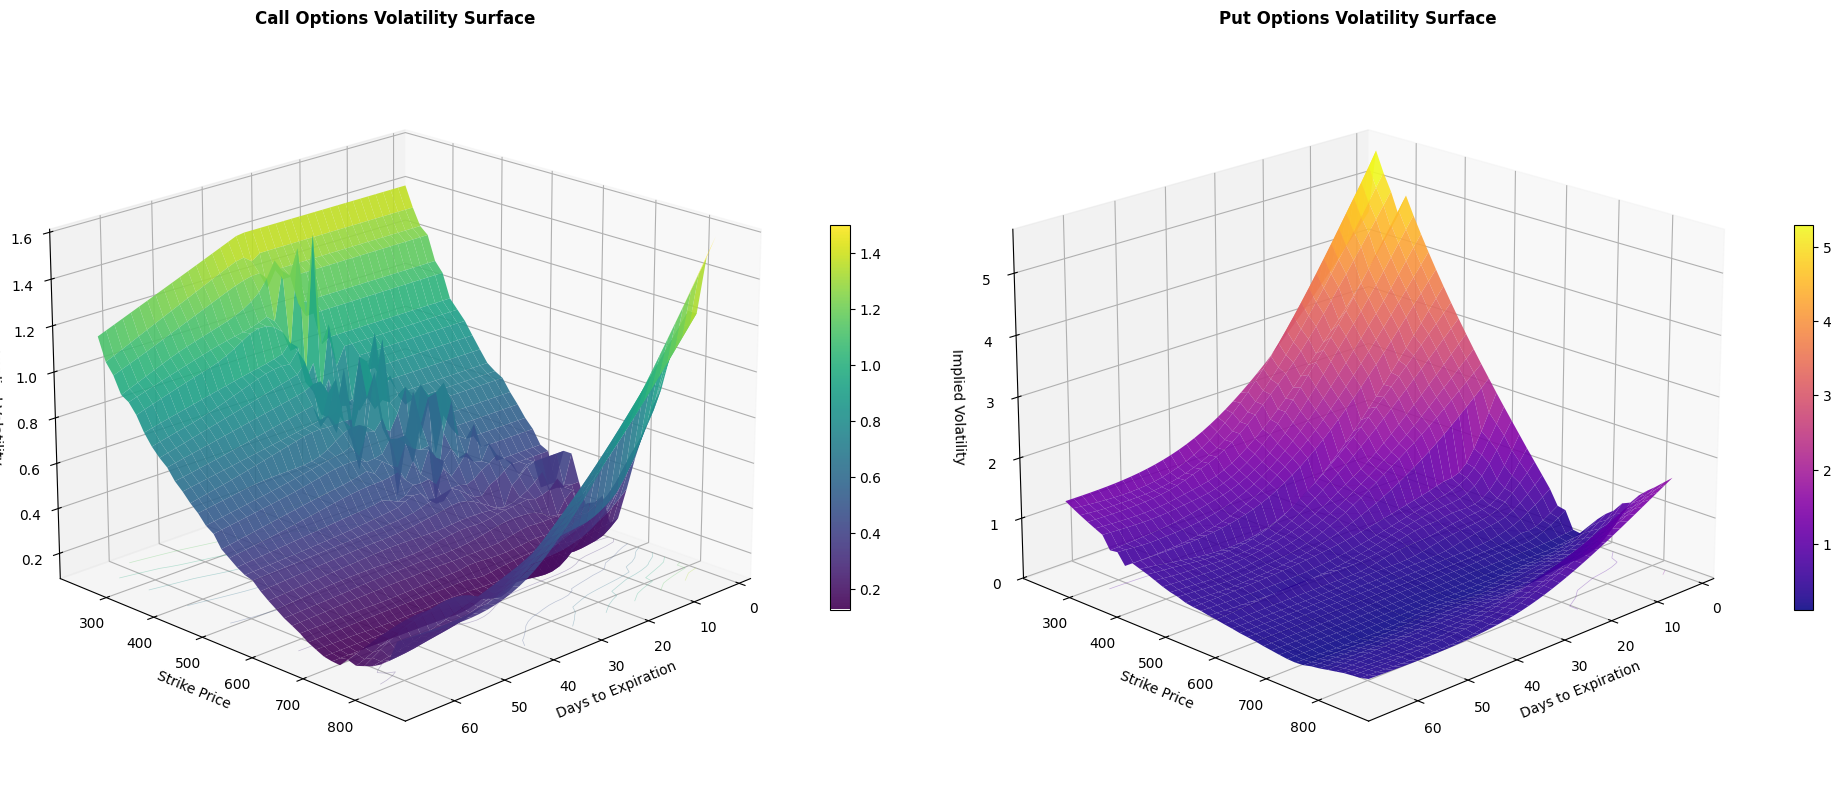


Volatility Surface Summary (both):
Data points: 1687
Volatility range: 0.118 - 6.411
Days to expiration range: 2 - 65
Strike range: $245.00 - $850.00


In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from datetime import datetime
from scipy.interpolate import griddata

def create_volatility_surface(chain_data, option_type='call', figsize=(15, 10), grid_resolution=50):
    """
    Create a 3D volatility surface plot as a smooth sheet
    
    Parameters:
    chain_data: DataFrame with columns exp_date, strike, volatility, type
    option_type: 'call', 'put', or 'both'
    figsize: tuple for figure size
    grid_resolution: int, resolution of the interpolated grid (higher = smoother)
    """
    
    # Filter data
    df = chain_data.copy()
    df = df[df['volatility'] > 0]  # Remove zero volatilities
    
    if option_type in ['call', 'put']:
        df = df[df['type'] == option_type]
    
    # Convert exp_date to days to expiration
    df['exp_date'] = pd.to_datetime(df['exp_date'])
    today = pd.to_datetime(datetime.today().date())
    df['days_to_exp'] = (df['exp_date'] - today).dt.days
    
   
    
    if option_type == 'both':
        fig = plt.figure(figsize=(20, 8))
        
        # Calls subplot
        ax1 = fig.add_subplot(121, projection='3d')
        calls_df = df[df['type'] == 'call']
        if not calls_df.empty:
            _create_smooth_surface(ax1, calls_df, 'Call Options Volatility Surface', 
                                 'viridis', grid_resolution)
        
        # Puts subplot
        ax2 = fig.add_subplot(122, projection='3d')
        puts_df = df[df['type'] == 'put']
        if not puts_df.empty:
            _create_smooth_surface(ax2, puts_df, 'Put Options Volatility Surface', 
                                 'plasma', grid_resolution)
            
    else:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
        
        if not df.empty:
            _create_smooth_surface(ax, df, f'{option_type.capitalize()} Options Volatility Surface', 
                                 'viridis', grid_resolution)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nVolatility Surface Summary ({option_type}):")
    print(f"Data points: {len(df)}")
    if not df.empty:
        print(f"Volatility range: {df['volatility'].min():.3f} - {df['volatility'].max():.3f}")
        print(f"Days to expiration range: {df['days_to_exp'].min()} - {df['days_to_exp'].max()}")
        print(f"Strike range: ${df['strike'].min():.2f} - ${df['strike'].max():.2f}")

def _create_smooth_surface(ax, df, title, colormap, grid_resolution):
    """Helper function to create smooth surface on given axis"""
    
    # Create regular grid for interpolation
    days_range = np.linspace(df['days_to_exp'].min(), df['days_to_exp'].max(), grid_resolution)
    strike_range = np.linspace(df['strike'].min(), df['strike'].max(), grid_resolution)
    Days, Strikes = np.meshgrid(days_range, strike_range)
    
    # Interpolate volatility values onto the grid
    points = df[['days_to_exp', 'strike']].values
    values = df['volatility'].values
    
    try:
        # Try cubic interpolation first
        Vol_surface = griddata(points, values, (Days, Strikes), method='cubic')
        
        # Fill NaN values with linear interpolation
        if np.isnan(Vol_surface).any():
            Vol_surface_linear = griddata(points, values, (Days, Strikes), method='linear')
            Vol_surface = np.where(np.isnan(Vol_surface), Vol_surface_linear, Vol_surface)
        
        # Fill remaining NaN values with nearest neighbor
        if np.isnan(Vol_surface).any():
            Vol_surface_nearest = griddata(points, values, (Days, Strikes), method='nearest')
            Vol_surface = np.where(np.isnan(Vol_surface), Vol_surface_nearest, Vol_surface)
        
        # Create the smooth surface
        surface = ax.plot_surface(Days, Strikes, Vol_surface, 
                                cmap=colormap, alpha=0.9, 
                                linewidth=0, antialiased=True,
                                shade=True)
        
        # Add contour lines for better visualization
        ax.contour(Days, Strikes, Vol_surface, zdir='z', offset=Vol_surface.min(), 
                  cmap=colormap, alpha=0.3, linewidths=0.5)
        
        # Add colorbar
        plt.colorbar(surface, ax=ax, shrink=0.5, aspect=20)
        
    except Exception as e:
        print(f"Could not create smooth surface: {e}")
        # Fallback to scatter plot
        scatter = ax.scatter(df['days_to_exp'], df['strike'], df['volatility'], 
                           c=df['volatility'], cmap=colormap, alpha=0.6, s=20)
        plt.colorbar(scatter, ax=ax, shrink=0.5)
    
    # Customize the plot
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Days to Expiration', fontsize=10)
    ax.set_ylabel('Strike Price', fontsize=10)
    ax.set_zlabel('Implied Volatility', fontsize=10)
    
    # Improve viewing angle
    ax.view_init(elev=20, azim=45)

# Create volatility surfaces with smooth sheets
# create_volatility_surface(chain.chain, option_type='call', grid_resolution=50)
# create_volatility_surface(chain.chain, option_type='put', grid_resolution=50) 
create_volatility_surface(chain.chain, option_type='both', grid_resolution=40)